# LSTM

- reference: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Omajinai

In [1]:
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM #, GRU, Bidirectional
import tensorflow as tf

## Data

In [3]:
!wget https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv -O newly_confirmed_cases_daily.csv

--2022-01-11 21:51:31--  https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv
Resolving covid19.mhlw.go.jp (covid19.mhlw.go.jp)... 13.33.210.110, 13.33.210.126, 13.33.210.11, ...
Connecting to covid19.mhlw.go.jp (covid19.mhlw.go.jp)|13.33.210.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96469 (94K) [application/octet-stream]
Saving to: ‘newly_confirmed_cases_daily.csv’

newly_confirmed_cas 100%[===================>]  94.21K  --.-KB/s    in 0.02s   

2022-01-11 21:51:31 (5.91 MB/s) - ‘newly_confirmed_cases_daily.csv’ saved [96469/96469]



In [4]:
df = pd.read_csv('newly_confirmed_cases_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)
print(df.shape)
display(df.head(1))
display(df.tail(5))

(726, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-06,4301,74,1,6,12,2,2,8,34,51,...,6,5,80,19,10,24,8,6,61,981
2022-01-07,6074,94,9,8,7,0,3,18,58,52,...,24,4,135,36,29,31,16,9,110,1414
2022-01-08,8311,132,12,10,31,1,10,33,102,69,...,38,4,229,58,32,59,27,24,180,1759
2022-01-09,8078,117,17,4,25,3,5,35,75,41,...,45,8,211,49,31,61,24,17,108,1533
2022-01-10,6273,106,10,1,14,6,11,21,48,44,...,47,9,214,55,49,76,32,11,107,779


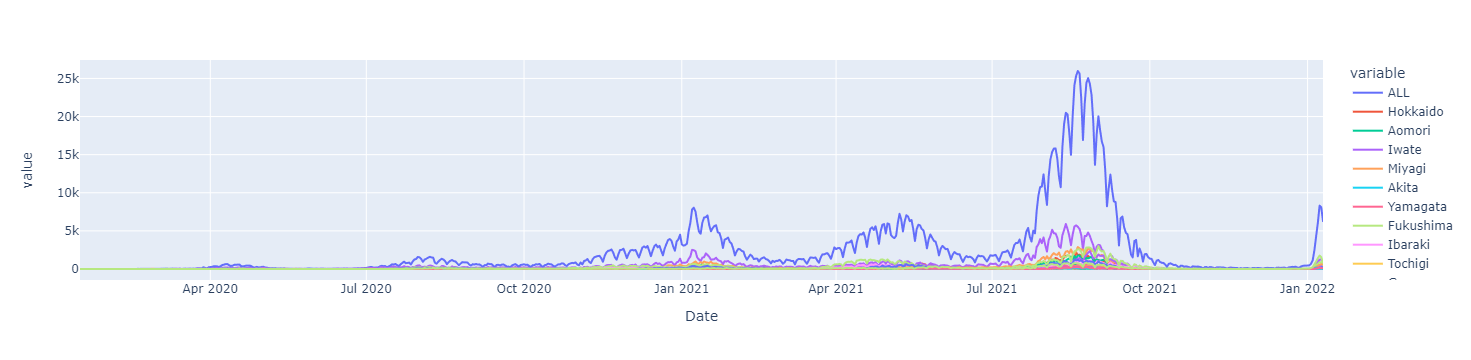

In [5]:
px.line(df, )

In [17]:
df_gr = df.groupby(pd.Grouper(level='Date', freq='W')).mean()
df_gr = df_gr.drop(df_gr.index[-1])
last_date = df_gr.index[-1]
print(df_gr.shape)
display(df_gr.head(1))
display(df_gr.tail(5))

(104, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-19,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-12,114.857143,3.428571,0.428571,0.000000,0.428571,0.142857,1.000000,1.000000,2.000000,1.571429,...,0.000000,0.000000,3.857143,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,3.428571
2021-12-19,148.285714,8.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,1.142857,1.571429,...,0.000000,0.000000,2.571429,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.571429
2021-12-26,223.857143,20.714286,0.000000,0.000000,0.285714,0.000000,0.142857,2.714286,1.428571,5.285714,...,0.000000,0.000000,10.857143,0.428571,0.857143,0.142857,0.000000,0.000000,1.428571,18.000000
2022-01-02,379.285714,21.428571,0.285714,0.714286,0.428571,0.000000,0.142857,2.285714,1.428571,11.571429,...,0.000000,0.142857,7.142857,0.857143,0.428571,0.000000,0.000000,0.000000,0.428571,36.857143
2022-01-09,4439.857143,69.571429,7.714286,5.142857,12.714286,0.857143,5.000000,15.714286,42.428571,41.142857,...,17.428571,4.285714,104.285714,26.142857,17.857143,25.857143,11.285714,8.571429,69.714286,952.142857


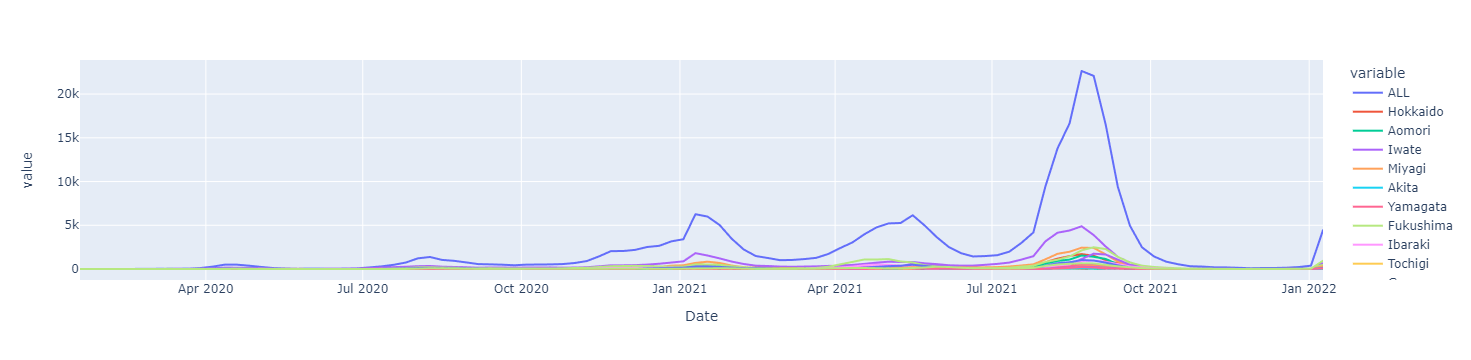

In [7]:
px.line(df_gr,)

### Scale

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
ts_all = df_gr.ALL
ts_all_sc = sc.fit_transform(ts_all.values.reshape(-1, 1)).ravel()
ts_all_sc = pd.Series(ts_all_sc, index=ts_all.index)
ts_all_sc.head(1)

Date
2020-01-19    0.0
Freq: W-SUN, dtype: float64

### FE

In [9]:
forecast_weeks = 12
# df_fe = df_gr.ALL.to_frame()
df_fe = ts_all_sc.to_frame(name='ALL')

# add new rows for forecast
index_list = pd.date_range(ts_all_sc.index[-1]+relativedelta(weeks=1), ts_all_sc.index[-1]+relativedelta(weeks=forecast_weeks), freq='W')
df_fe = pd.concat([df_fe, pd.DataFrame(index=index_list)])

# shift
for i in range(forecast_weeks, forecast_weeks+12):
    df_fe[f'ALL_{i}_week_ago'] = df_fe.ALL.shift(i)
# df_fe[f'ALL_12_week_ago'] = df_fe.ALL.shift(12)
df_fe['year'] = df_fe.index.year
df_fe['month'] = df_fe.index.month
df_fe['weekofyear'] = df_fe.index.isocalendar().week
df_fe = df_fe.astype('float')
df_fe = df_fe.loc[df_fe.ALL_23_week_ago.dropna().index, :]
df_fe

,ALL,ALL_12_week_ago,ALL_13_week_ago,ALL_14_week_ago,ALL_15_week_ago,ALL_16_week_ago,ALL_17_week_ago,ALL_18_week_ago,ALL_19_week_ago,ALL_20_week_ago,ALL_21_week_ago,ALL_22_week_ago,ALL_23_week_ago,year,month,weekofyear
2020-06-28,0.003517,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,0.000008,0.000039,0.000008,0.000000,2020.0,6.0,26.0
2020-07-05,0.008023,0.021946,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,0.000008,0.000039,0.000008,2020.0,7.0,27.0
2020-07-12,0.013331,0.021883,0.021946,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,0.000008,0.000039,2020.0,7.0,28.0
2020-07-19,0.021271,0.016771,0.021883,0.021946,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,0.000008,2020.0,7.0,29.0
2020-07-26,0.032663,0.010371,0.016771,0.021883,0.021946,0.012037,0.004931,0.001699,0.002002,0.001478,0.000696,0.000475,0.000084,2020.0,7.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-06,NaN,0.005063,0.004937,0.003965,0.005985,0.007922,0.008471,0.012265,0.013969,0.023846,0.037100,0.063273,0.109580,2022.0,3.0,9.0
2022-03-13,NaN,0.006540,0.005063,0.004937,0.003965,0.005985,0.007922,0.008471,0.012265,0.013969,0.023846,0.037100,0.063273,2022.0,3.0,10.0
2022-03-20,NaN,0.009879,0.006540,0.005063,0.004937,0.003965,0.005985,0.007922,0.008471,0.012265,0.013969,0.023846,0.037100,2022.0,3.0,11.0
2022-03-27,NaN,0.016746,0.009879,0.006540,0.005063,0.004937,0.003965,0.005985,0.007922,0.008471,0.012265,0.013969,0.023846,2022.0,3.0,12.0


### split

In [10]:
X = df_fe.drop('ALL', axis=1)
y = df_fe.ALL
print(X.shape, y.shape)

(93, 15) (93,)


## functions

In [11]:
# https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_loss = np.Inf
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        if loss < 0.001:
            if np.less(val_loss, self.best_val_loss):
                self.best_loss = loss
                self.best_val_loss = val_loss
                self.wait = 0
                # Record the best weights if current results is better (less).
                self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    self.model.set_weights(self.best_weights)

In [12]:
n_units = 32
dropout = 0.1
n_batch_size = 32
n_epochs = 10000

from keras.callbacks import EarlyStopping
es_loss = EarlyStopping(monitor='loss', patience=100)
es_val_loss = EarlyStopping(monitor='loss', patience=200)

def trainLSTM(X_train, y_train):
    tf.random.set_seed(42)
    
    # val
    X_val = X_train[X_train.index == X_train.index[-1]]
    X_train = X_train.drop(X_train.index[-1])
    y_val = y_train[y_train.index == y_train.index[-1]]
    y_train = y_train.drop(y_train.index[-1])
    
    # The LSTM architecture
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # Second LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True))
    # Third LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True))
    # Fourth LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout))
    # The output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fitting to the training set
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=n_epochs, batch_size=n_batch_size, verbose=0, 
        #callbacks=[es_loss]
        callbacks=[es_val_loss]
        #callbacks=[CustomEarlyStopping(patience=100)]
    )

    return model, history

## forecast

(81, 15) (81,)
loss: 0.0080436
val_loss: 0.019447
CPU times: user 42.5 s, sys: 13.4 s, total: 55.9 s
Wall time: 43.9 s


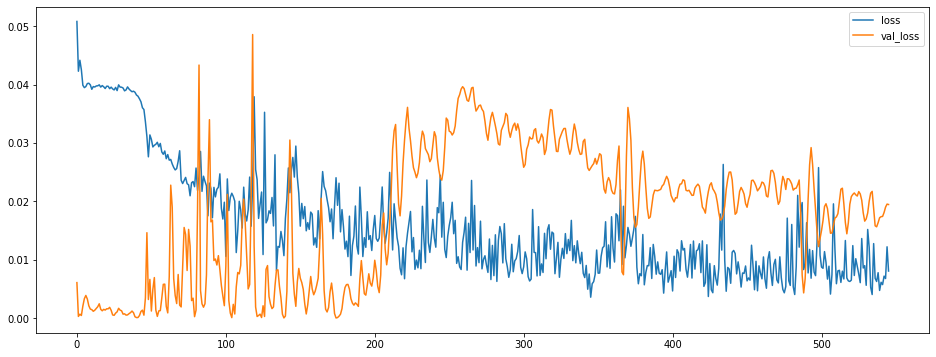

In [18]:
%%time

X_train = X[X.index <= last_date]
y_train = y[y.index <= last_date]
print(X_train.shape, y_train.shape)

model, history = trainLSTM(X_train, y_train)
print('loss: {:.5}'.format(history.history['loss'][-1]))
print('val_loss: {:.5}'.format(history.history['val_loss'][-1]))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

RMSE: 1039.0


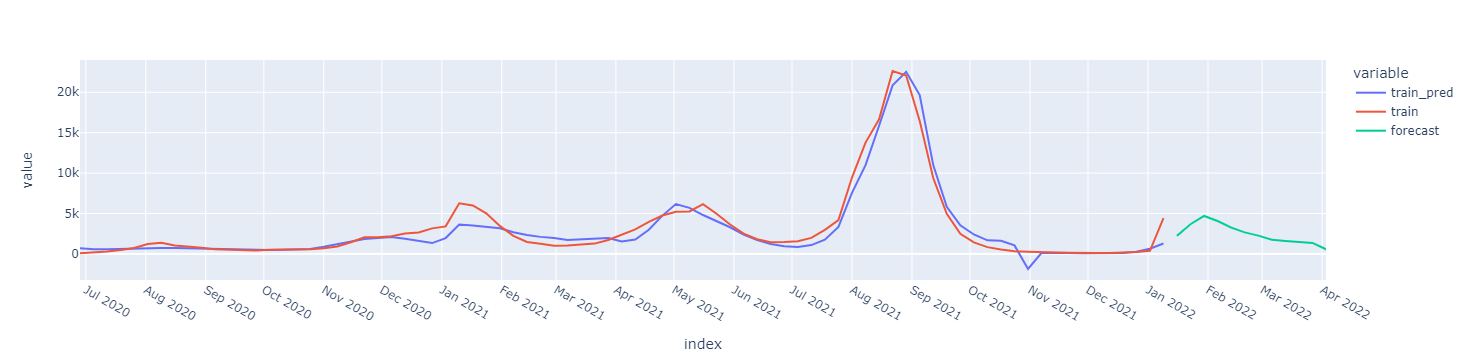

In [19]:
X_train = X[X.index <= last_date]
y_train = y[y.index <= last_date]
y_train_index = y_train.index

y_pred = model.predict(X_train)
y_pred = sc.inverse_transform(y_pred).ravel()
y_pred = pd.Series(y_pred, index=y_train_index, name='train_pred')
y_train = sc.inverse_transform(y_train.values.reshape(-1, 1)).ravel()
y_train = pd.Series(y_train, index=y_train_index, name='train')

rmse = np.sqrt( mean_squared_error(y_train, y_pred) )
print('RMSE: {:.5}'.format(rmse))

X_forecast = X[X.index > last_date]
y_forecast = y[y.index > last_date]
y_forecast_index = y_forecast.index

y_forecast = model.predict(X_forecast)
y_forecast = sc.inverse_transform(y_forecast).ravel()
y_forecast = pd.Series(y_forecast, index=y_forecast_index, name='forecast')

# plt.plot(y_pred, label='train pred')
# plt.plot(y_train, label='test')
# plt.plot(y_forecast, label='forecast')
# plt.legend()

fig = px.line(pd.concat([y_pred, y_train, y_forecast], axis=1))
fig.update_layout({
    'xaxis': {
        'dtick': 'M1'
    }
})
fig.show()

## benchmark

In [15]:
%%time
def auto(X, y):
    pass

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


In [16]:
# Preparing X_test and predicting
X_test = []
index_list = []
for i in range(n_timestep, ts_test_sc.shape[0]):
    X_test.append(ts_test_sc.iloc[i-n_timestep:i])
    index_list.append(ts_test_sc.iloc[i].name)
X_test = np.array(X_test)
print(X_test.shape)

NameError: name 'n_timestep' is not defined

In [ ]:
y_pred = regressor.predict(X_test)
y_pred = sc.inverse_transform(y_pred)
ts_pred = pd.DataFrame(y_pred, index=index_list, columns=['pred'])

In [ ]:
df_temp = pd.concat([ts_test, ts_pred], axis=1)
px.line(df_temp)